In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay

from textwrap import wrap

from components.scaler import Scaler
from components.imputer import Imputer
from components.one_hot_encoder import OneHotEncoder


pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [64]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,birth weight,birth length,week of gestation,age
141,0,NaN,67.79,NaN,69.0,171.0,23.597004,NaN,NaN,NaN,82.0,0.0,97.0,0.845361,0.0,1.0,0.479532,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,6.831000,5.145000,11.976000,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,6.48,3.96,2.02,0.38,0.10,0.02,61.1,31.2,5.9,1.5,0.3,4.44,13.2,39.7,3.007576,89.4,29.7,33.2,12.8,0.00,238.0,12.5,10.8,31.1,36.728395,0.045378,117.821782,5.315789,1.960396,0.311728,0.015432,NaN,NaN,NaN,NaN,0.63,NaN,NaN,NaN,NaN,135.0,3.49110,0.0,53.0,1.37058,0.0,70.8,1.830888,0.0,58.0,0.65482,0.0,1.335849,1.094340,0.905628,38.725146,15.71568,4.296521,0.039152,NaN,NaN,NaN,NaN,NaN,93.0,103.0,15.12,NaN,3.472000,NaN,0.317659,0.0,0.0,1.14,5.06,17.20,11.0,10.0,5.6,13.9,2.482143,NaN,244.0,1.2,0.345821,0.015171,NaN,NaN,NaN,NaN,NaN,79.1,1.45,NaN,NaN,NaN,2.52,2.05,NaN,NaN,0.476190,8.0,3.0,NaN,NaN,NaN,23.0
907,3,236.0,NaN,NaN,52.0,161.0,20.060954,110.0,75.0,0.0,71.0,0.0,83.0,0.855422,1.0,1.0,0.440994,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,4.582500,6.624000,11.206500,2.0,1.0,1.739,6.33906,8.07806,0.0,0.0,0.0,5.45,2.47,1.77,0.57,0.55,0.09,45.2,32.5,10.5,10.1,1.7,4.57,14.5,41.8,2.882759,91.5,31.7,34.7,11.9,0.00,311.0,11.8,10.4,28.2,57.064220,0.033441,175.706215,3.105263,1.395480,0.324771,0.100917,142.0,4.14,9.76,4.30,0.82,1.5,13.0,22.0,0.51,174.0,4.49964,0.0,55.0,1.42230,0.0,100.7,2.604102,0.0,90.0,1.01610,0.0,1.830909,1.636364,1.277715,33.552795,13.20930,4.428259,0.213

In [65]:
df.shape

(999, 146)

In [66]:
target_column = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'

igf = 'IGF-1 ng/ml (N: 100-311)'
vit_d = 'vitamin 25-OH D ng/ml'
prolactin = 'prolactin'

important_attributes = [igf, vit_d, prolactin]

(array([232.,   0., 510.,   0.,   0., 145.,   0.,  27.,   0.,  85.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

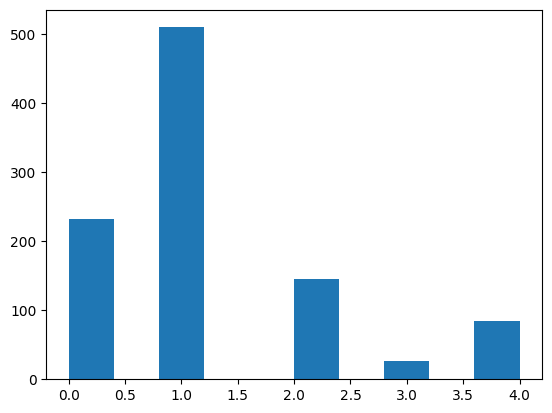

In [67]:
plt.hist(df[target_column])

### Data preprocessing

### Attribute groups

In [69]:
categorical_attributes = [
    'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'Hypertension', 'WC>88', 'WHR>0,85 (WHO)', 'WHR>0,8 (NIDDK)', 'WHTR>0,5', 
    'overweight/obesity 0-normal/low, 1-overweight, 2-obesity', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'hyperandrogenism', 'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'chronic thyroiditis',
    'follicules >12', 'hyperlipidemia', 'elevated LDL and TG', 'CHOL>200', 'HDL<50', 'LDL>135', 'TG>150', 'Impaired Fasting Glucose ', 'Impaired Glucose Tolerance', 
    'month of birth', 'quarter of the year',
    ]

continuous_attributes = list(df.columns.drop(categorical_attributes))

# parametry związane z układem krążenia i ryzykiem jego chorób
circulatory_system_attributes = [
    'proBNP', 'systolic BP (ciśnienie skurczowe)', 'diastolic BP (ciśnienie rozskurczowe)', 'Hypertension', 'hyperlipidemia', 'elevated LDL and TG',
    'CHOL mg/dl ', 'CHOL mmol/l', 'CHOL>200', ' HDL mg/dl', 'HDL mmol/l', 'HDL<50', 'LDL mg/dl', 'LDL mmol/l', 'LDL>135', 'TG', 'TG mmol/l', 'TG>150',
    'Atherogenic index (AI) (LDL-C/HDL-C) ', 'coronary risk index (CRI) (TG/HDL-C)', 'VAI - Visceral adiposity index', 'BAI - Body adiposity index',
    'LAP INDEX - Lipid accumulation product index', 'TyG Index - Trigliceride-glucose index', 'AIP -Atherogenic index of plasma',
    ]
# hormony płciowe plus morfologia jajnika
sex_hormones_attributes = [
    'AMH (ng/ml) *7,14=pmol/l', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'hyperandrogenism',
    'Vole of the Right Ovary', 'Volume of the  Left Ovary', 'ovaries volume - total', 'follicules >12', 'FSH mlU/ml', 'LH', 'LH/FSH', 'DHEA-S ug/dl', 'testosterone nmol/l',
    'T (ng/ml)', 'T/SHBG', 'E(pg/ml)/T(ng/ml)/', 'Estradiol pg/ml', 'SHBG nmol/l', 'FTI (free testosterone index)', 'Androstendione ng/ml', '17-OH-progesterone ng/ml',
    'Dihydrotestosterone pg/ml (N<368)', 'Testosterone/DHT', 'T/A (testosterone/androstendione)',
    ]
# gospodarka węglowodanowa (włączając oporność i wrazliwość na insulinę)
carbohydrate_metabolism_attributes = [
    'glucose 0 mg/dl', 'glucose  120 mg/dl', 'insulin 0 uU/ml', 'Insulin 120 uU/ml', 'HOMA', 'Matsuda', 'QUICKI (N<0,357)', 'Impaired Fasting Glucose ',
    'Impaired Glucose Tolerance',
    ]
# parametry antropometryczne
anthropometric_attributes = [
    'weight', 'height (cm)', 'BMI', 'Waist Circumference (WC)', 'WC>88', 'Hip Circumference (HC)', 'WHR (Waist/Hip ratio)', 'WHR>0,85 (WHO)',
    'WHR>0,8 (NIDDK)', 'WHTR (Waist/Height Ratio)', 'WHTR>0,5', 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
    ]
# parametry tarczycowe
thyroid_attributes = [
    'hypothyroidism', 'Volume of the thyroid  Right Lobe', 'Volume of the thyroid  Left Lobe', 'thyroid volume', 'nodules 0-lack, 1-RL,  2-LL, 3-both',
    'chronic thyroiditis', 'TSH mIU/L', 'FT3 pmol/l', 'FT4 pmol/l', 'Anty-TPO IU/ml', 'Anty-TG IU/ml',
    ]
# parametry zapalne
inflammatory_attributes = [
    'WBC x10^3/ul', 'neutrophil x10^3/ul', 'lymphocytes x10^3/ul', 'monocytes x10^3/ul', 'eosinocytes x10^3/ul', 'basophils x10^3/ul', '% neutrophil ', '% lymphocytes ',
    '% monocytes', '%eosinocytes ', '%basophils ', 'RBC x10^6ul', 'Hemoglobin [g/dl]', 'hematocrit [%]', 'HTC/Hb', 'MCV fl', 'MCH pg', 'MCHC g/dl', 'RDW-CV %', 'NRBC x10^3/ul',
    'PLT x10^3/ul', 'PDW fl', 'MPV fl', 'P-LCR %', 'PLT/WBC', 'MPV/PLT', 'PLR', 'limf/mono', 'NLR (stosunek neutrofili do limfocytów)',
    'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'CRP mg/l',
    ]
#  gospodarka żelazowa
iron_attributes = ['UIBC ug/dl', 'ferrum ug/dl', 'TIBC', 'TSAT', 'ferritin ng/ml']
# gospodarka wapniowo-fosforanowa
calcium_attributes = ['calcium mg/dl', 'phosphorus mg/dl', 'Parathormone pg/ml']

attribute_groups = [
    circulatory_system_attributes, sex_hormones_attributes, carbohydrate_metabolism_attributes, anthropometric_attributes,
    thyroid_attributes, inflammatory_attributes, iron_attributes, calcium_attributes]

In [70]:
df[categorical_attributes] = df[categorical_attributes].astype('Int8')
df[continuous_attributes] = df[continuous_attributes].astype('Float64')

In [71]:
continuous_attributes

['IGF-1 ng/ml (N: 100-311)',
 'proBNP',
 'AMH (ng/ml) *7,14=pmol/l',
 'weight',
 'height (cm)',
 'BMI',
 'systolic BP (ciśnienie skurczowe)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'Waist Circumference (WC)',
 'Hip Circumference (HC)',
 'WHR (Waist/Hip ratio)',
 'WHTR (Waist/Height Ratio)',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'Volume of the thyroid  Right Lobe',
 'Volume of the thyroid  Left Lobe',
 'thyroid volume',
 'Vole of the Right Ovary',
 'Volume of the  Left Ovary',
 'ovaries volume - total',
 'WBC x10^3/ul',
 'neutrophil x10^3/ul',
 'lymphocytes x10^3/ul',
 'monocytes x10^3/ul',
 'eosinocytes x10^3/ul',
 'basophils x10^3/ul',
 '% neutrophil ',
 '% lymphocytes ',
 '% monocytes',
 '%eosinocytes ',
 '%basophils ',
 'RBC x10^6ul',
 'Hemoglobin [g/dl]',
 'hematocrit [%]',
 'HTC/Hb',
 'MCV fl',
 'MCH pg',
 'MCHC g/dl',
 'RDW-CV %',
 'NRBC x10^3/ul',
 'PLT x10^3/ul',
 'PDW fl',
 'MPV fl',
 'P-LCR %',
 'PLT/WBC',
 'MPV/PLT',
 'PLR',
 'limf/mono',
 'NLR 

## Train test split

In [72]:
igf_df = df.dropna(subset=[igf])

X, y = igf_df.drop(columns=[igf]), igf_df[igf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Scaling

In [73]:
X_train.head()

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
765,2,17.08,4.822129,72.0,170.0,24.913495,122.0,74.0,0,71.0,0,90.0,0.788889,0,0,0.417647,0,0,1,<NA>,<NA>,<NA>,0,1,8.0,1,0,13.2,8.55,21.75,0,1,<NA>,<NA>,<NA>,<NA>,0,0,5.62,3.49,1.57,0.33,0.21,0.02,62.1,27.9,5.9,3.7,0.4,4.5,13.3,39.0,2.932331,86.7,29.6,34.1,11.7,0.0,208.0,12.7,10.7,31.0,37.010676,0.051442,132.484076,4.757576,2.22293,0.279359,0.037367,143.0,4.17,9.66,3.54,0.73,0.7,8.0,12.0,0.35,175.0,4.5255,0,77.0,1.99122,0,89.4,2.311884,0,46.0,0.51934,0,1.161039,0.597403,0.415334,34.941176,6.75142,4.158639,-0.223733,<NA>,96.0,343.0,28.0,36.0,89.0,92.0,13.26,40.42,2.913926,4.77,0.325528,0,0,2.77,4.85,15.23,8.0,10.0,6.0,8.3,1.383333,311.0,335.0,0.8,0.230548,0.013378,147.474999,32.45,215.0,58.0,34.0,59.8,1.27,15.76,4.6,9.0,3.2,1.4,205.0,0.003902,0.25,11,4,22.0
657,1,44.12,34.42,71.0,170.0,24.567474,126.0,86.0,0,80.0,0,86.0,0.930233,1,1,0.470588,0,0,1,0,1,1,0,1,10.0,1,1,6.375,5.64,12.015,0,1,18.7,22.59,41.29,1,0,0,6.37,3.59,1.68,0.47,0.56,0.07,53.6,26.4,7.4,8.8,1.1,4.28,13.3,37.8,2.842105,88.3,31.1,35.2,12.4,0.0,221.0,13.2,10.9,32.4,34.693878,0.049321,131.547619,3.574468,2.136905,0.263736,0.087912,144.0,4.28,9.5,2.21,0.95,0.6,8.0,15.0,0.7,184.0,4.75824,0,58.0,1.49988,0,99.7,2.578242,0,132.0,1.49028,0,1.718966,2.275862,1.796868,32.588235,32.78616,4.662727,0.357146,135.0,191.0,326.0,58.0,26.0,85.0,73.0,6.59,17.21,1.383086,13.78,0.363861,0,0,3.7,5.01,14.59,15.0,251.0,4.9,14.8,3.020408,311.0,193.0,2.7,0.778098,0.057325,100.24444

In [74]:
def get_continuous_attributes_except(attribute):
    remaining_attributes = continuous_attributes.copy()
    remaining_attributes.remove(attribute)
    return remaining_attributes

## Tests for scaling methods

In [75]:
def round_numeric_values(arr, decimals=5):
    # Create a mask to identify non-null numeric values
    mask = np.isnan(arr)
    # Round only the numeric values using the mask
    arr_rounded = np.where(mask, np.round(arr, decimals), arr)
    
    return arr_rounded


def test_scaler__scales_properly(scaling_method=RobustScaler()):
    column_1 = 'thyroid volume'
    column_2 = ' HDL mg/dl'
    column_3 = 'prolactin'
    columns_to_test = [column_1, column_2, column_3]


    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        # expected
        scaler = scaling_method
        expected_column = scaler.fit_transform(df_tmp[[column]])

        # result
        true_scaler = Scaler(scaling_method, attributes_to_scale=get_continuous_attributes_except(igf))
        scaled_df = true_scaler.fit_transform(df_tmp)
        result_column = scaled_df[[column]].astype('float64').values

        expected_column_rounded = round_numeric_values(expected_column)
        result_column_rounded = round_numeric_values(result_column)

        # Create masks to exclude NaN values
        expected_mask = ~np.isnan(expected_column_rounded)
        result_mask = ~np.isnan(result_column_rounded)

        try:
            # Compare only non-NaN values
            assert np.array_equal(expected_column_rounded[expected_mask], result_column_rounded[result_mask])
            print("===PASSED===", column)
        except AssertionError:
            diff_indices = np.where(expected_column_rounded != result_column_rounded)[0]
            print("---FAILED---", column)
            print(f"Arrays differ in column {column} at indices: {diff_indices}")
    

def test_scaler__categorical_variables_remain_unchanged(scaling_method=RobustScaler()):
    column_1 = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'
    column_2 = 'LDL>135'
    column_3 = 'Impaired Glucose Tolerance'

    columns_to_test = [column_1, column_2, column_3]

    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        scaler = Scaler(scaling_method, attributes_to_scale=get_continuous_attributes_except(igf))
        scaled_df = scaler.fit_transform(df_tmp)
        result_column = scaled_df[[column]].astype("Int8")

        try:
            assert result_column.equals(df_tmp[[column]])
            print("===PASSED===", column)
        except AssertionError:
            print("---FAILED---", column)


test_scaler__scales_properly(scaling_method=RobustScaler())
test_scaler__scales_properly(scaling_method=PowerTransformer())
test_scaler__categorical_variables_remain_unchanged(scaling_method=RobustScaler())
test_scaler__categorical_variables_remain_unchanged(scaling_method=PowerTransformer())

===PASSED=== thyroid volume
===PASSED===  HDL mg/dl
===PASSED=== prolactin
===PASSED=== thyroid volume
===PASSED===  HDL mg/dl
===PASSED=== prolactin
===PASSED=== PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro
===PASSED=== LDL>135
===PASSED=== Impaired Glucose Tolerance
===PASSED=== PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro
===PASSED=== LDL>135
===PASSED=== Impaired Glucose Tolerance


In [14]:
power_transformer_scaler = Scaler(PowerTransformer(), get_continuous_attributes_except(igf))
X_power_transformer = power_transformer_scaler.fit_transform(X_train)
X_power_transformer.head(5)

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-1.201959,-0.238295,0.388605,0.480548,0.218538,0.139139,0.025613,-0.585074,0.242228,-1.437601,-0.738427,0.434540,2.135583,1.613519,1.918527,NaN,NaN,NaN,-0.170029,0.124300,-0.630353,-0.950588,0.834528,-1.232432,0.583163,-0.537374,-0.948803,0.896019,-0.927444,0.033663,0.037037,0.002723,-0.106264,-0.085337,-0.037655,0.193406,-1.569725,-0.192847,-0.918639,0.153509,0.090547,0.140221,-0.561667,0.861168,-0.149897,0.319726,0.577379,-0.553325,0.975649,0.516055,-0.285259,0.199164,-0.160066,-0.024208,-0.259251,-1.734871,-1.394950,-0.414113,0.047795,0.048797,0.759850,0.764710,-0.110293,-0.110962,-1.182505,-1.200041,-0.522854,-1.223770,-1.338021,0.063745,-0.823343,-1.058225,-1.218069,NaN,0.195826,0.004263,0.109278,0.066227,0.178457,-0.232393,0.633744,-0.093519,0.630083,-0.446263,-0.598649,0.582213,-0.163476,-0.320397,-1.060252,-0.836272,0.234598,0.044501,-0.093056,-0.083425,0.280563,-1.086282,-1.107792,-0.897227,0.311334,-0.545987,-1.230920,-1.860876,-0.380020,0.115579,-0.937128,-0.459537,-1.480831,-1.651338,-0.079356,-1.081283,-1.256607,0.026700,-1.286192,-0.587502,2,0,0,0,0,0,0,1,<NA>,<NA>,<NA>,0,1,1,0,0,1,<NA>,0,0,0,0,0,0,0,0,11,4
657,0.229864,3.174402,0.331362,0.480548,0.158251,0.415999,1.097873,0.234766,-0.102514,0.576581,0.097572,0.672161,0.545595,0.832614,0.713049,1.525365,2.043600,1.958551,0.240178,0.192557,-0.407018,0.183753,2.022928,1.394953,-0.320481,-0.725705,-0.032152,2.228741,1.223567,-0.556054,0.037037,-0.414514,

In [15]:
def plot_continuous_attribute_distributions(X, columns):
    n_rows = 29
    n_cols = 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 120))

    for i, col in enumerate(columns):
        ax = axes[int(i/n_cols)][i%n_cols]
        sns.histplot(X[col], kde=True, ax=ax)
        ax.set_title("\n".join(wrap(col, 40)) + '\n')
        ax.set_xlabel('')

    fig.tight_layout()
    plt.show()

Power Transformer

In [16]:
columns_to_scale = get_continuous_attributes_except(igf)
power_transformer_scaler = Scaler(PowerTransformer(), columns_to_scale)
X_power_transformer = power_transformer_scaler.fit_transform(X_train)
# plot_continuous_attribute_distributions(X_power_transformer, columns_to_scale)

Robust Scaler

In [17]:
columns_to_scale = get_continuous_attributes_except(igf)
robust_scaler = Scaler(RobustScaler(), columns_to_scale)
X_train_robust_scaler = robust_scaler.fit_transform(X_train)
# X_robust_scaler.head(5)
X_test_robust_scaler = robust_scaler.transform(X_test)

# plot_continuous_attribute_distributions(X_robust_scaler, columns_to_scale)
# plot_continuous_attribute_distributions(X_val_robust_scaler, columns_to_scale)

## Handle missing data

- < 50% missing --> remove columns
- resztę -> zastapić mediana

In [18]:
imputer = SimpleImputer(strategy='median')
imputer.set_output(transform='pandas')

X_train_imputed = imputer.fit_transform(X_train_robust_scaler)
X_test_imputed = imputer.transform(X_test_robust_scaler)


X_train_imputed[categorical_attributes] = X_train_imputed[categorical_attributes].astype('Int8')
X_test_imputed[categorical_attributes] = X_test_imputed[categorical_attributes].astype('Int8')

In [19]:
X_train_imputed.head()

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,2,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,11,4
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.087233,0.4,0.429054,0.849857,0.635211,1.377593,2.259394e+00,1.937916e+00,0.157158,0.107246,-0.277027,0.166667,3.666667,1.5,-0.241715,-0.509091,-0.044944,3.884058,1.25,-0.44,0.076923,-0.303448,-0.812127,0.250000,0.666667,0.833333,-0.1818

## One-hot encoding

One-hot encoding for PCO, overweight, nodules

In [20]:
# class OneHotEncoder:
#     def __init__(self, columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=False):
#         self.columns_for_one_hot_encoding = columns_for_one_hot_encoding
#         self.new_column_names_map = new_column_names_map
#         self.advanced_encoding = advanced_encoding

#     def fit(self, X, y=None):
#         # there's no fitting, we apply the same one hot encoding to all data sets
#         pass

#     def fit_transform(self, X, y=None):
#         for col, prefix in self.columns_for_one_hot_encoding.items():
#             X = pd.get_dummies(X, columns=[col], prefix=prefix, dtype=np.int8)

#         X = X.rename(columns=self.new_column_names_map)

#         # more advanced encoding for nodules:
#         # if nodules_both_sides = 1, then nodules_right = 1 and nodules_left = 1
#         if self.advanced_encoding:
#             X['nodules_right'] = X['nodules_right'] | X['nodules_both_sides']
#             X['nodules_left'] = X['nodules_left'] | X['nodules_both_sides']
#         # 
#         return X
    
#     def transform(self, X, y=None):
#         for col, prefix in self.columns_for_one_hot_encoding.items():
#             X = pd.get_dummies(X, columns=[col], prefix=prefix, dtype=np.int8)

#         X = X.rename(columns=self.new_column_names_map)

#         # more advanced encoding for nodules:
#         # if nodules_both_sides = 1, then nodules_right = 1 and nodules_left = 1
#         if self.advanced_encoding:
#             X['nodules_right'] = X['nodules_right'] | X['nodules_both_sides']
#             X['nodules_left'] = X['nodules_left'] | X['nodules_both_sides']
#         # 
#         return X
    
#     def get_categorical_attributes_list(self, categorical_attributes):
#         #  remove no longer existing columns
#         for old_col in self.columns_for_one_hot_encoding.keys():
#             if old_col in categorical_attributes:
#                 categorical_attributes.remove(old_col)

#         # add new columns
#         for new_col in self.new_column_names_map.values():
#             if new_col not in categorical_attributes:
#                 categorical_attributes.append(new_col)

#         return categorical_attributes
    
#     def get_name(self):
#         if self.advanced_encoding:
#             return "advanced"
#         else:
#             return "basic"

In [21]:
columns_for_one_hot_encoding = {'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro': 'PCO',
                             'overweight/obesity 0-normal/low, 1-overweight, 2-obesity': 'overweight',
                             'nodules 0-lack, 1-RL,  2-LL, 3-both': 'nodules',
                             'quarter of the year': 'birth_quarter',
                             'month of birth': 'birth_month',
                             }

new_column_names_map = {
    'PCO_0': '0_healthy_control',
    'PCO_1': '1_PCOS',
    'PCO_2': '2_FHA',
    'PCO_3': '3_POF',
    'PCO_4': '4_High_Andro',
    'overweight_0': '0_normal_weight',
    'overweight_1': '1_overweight',
    'overweight_2': '2_obesity',
    'nodules_0': 'no_nodules',
    'nodules_1': 'nodules_right',
    'nodules_2': 'nodules_left',
    'nodules_3': 'nodules_both_sides',
    }

one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)

X_train_encoded = one_hot_encoder.fit_transform(X_train_imputed)
X_test_encoded = one_hot_encoder.fit_transform(X_test_imputed)

# categorical_attributes = one_hot_encoder.update_categorical_attributes_list(categorical_attributes)

In [22]:
X_train_imputed.head()

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,month of birth,quarter of the year
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,2,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,11,4
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.087233,0.4,0.429054,0.849857,0.635211,1.377593,2.259394e+00,1.937916e+00,0.157158,0.107246,-0.277027,0.166667,3.666667,1.5,-0.241715,-0.509091,-0.044944,3.884058,1.25,-0.44,0.076923,-0.303448,-0.812127,0.250000,0.666667,0.833333,-0.1818

In [23]:
X_train_encoded.head(5)

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Waist Circumference (WC),Hip Circumference (HC),WHR (Waist/Hip ratio),WHTR (Waist/Height Ratio),FG score (Ferriman-Gallway score - stopień androgenizacji),Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,HDL mg/dl,HDL mmol/l,LDL mg/dl,LDL mmol/l,TG,TG mmol/l,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,Hypertension,WC>88,"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)","WHTR>0,5","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,hyperandrogenism,hypothyroidism,chronic thyroiditis,follicules >12,hyperlipidemia,elevated LDL and TG,CHOL>200,HDL<50,LDL>135,TG>150,Impaired Fasting Glucose,Impaired Glucose Tolerance,0_healthy_control,1_PCOS,2_FHA,3_POF,4_High_Andro,0_normal_weight,1_overweight,2_obesity,no_nodules,nodules_right,nodules_left,nodules_both_sides,birth_quarter_1,birth_quarter_2,birth_quarter_3,birth_quarter_4,birth_month_1,birth_month_2,birth_month_3,birth_month_4,birth_month_5,birth_month_6,birth_month_7,birth_month_8,birth_month_9,birth_month_10,birth_month_11,birth_month_12
765,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,-0.25,0.235294,-1.083235,-0.366798,0.2,2.622529,2.180903,2.565227,0.000000,1.435484e-16,-1.454728e-16,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.590909,0.590909,-0.079845,-0.079845,-0.590909,-0.590909,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,-0.375,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
657,0.204705,5.378816e+00,0.300000,0.444444,0.183272,0.333333,0.958333,0.20,0.000000,0.378726,0.

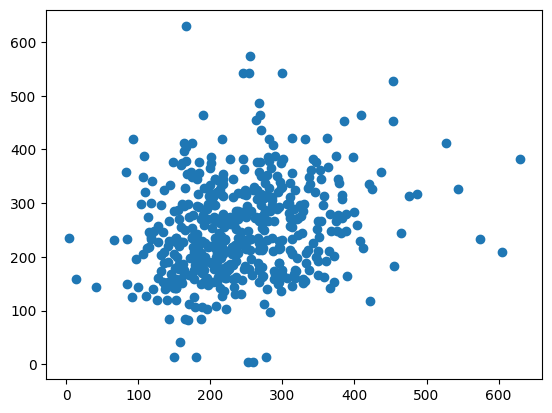

In [24]:
model = DecisionTreeRegressor(max_depth=20, random_state=42)
y_train_pred = cross_val_predict(model, X_train_encoded, y_train, cv=5)
plt.scatter(y_train, y_train_pred)

In [25]:


model = DecisionTreeRegressor(max_depth=15, random_state=42)
score = cross_val_score(model, X_train_encoded, y_train, cv=5)
# plt.scatter(y_train, y_train_pred)
score

array([-0.49139741, -0.60066121, -0.62922407, -1.28547399, -0.55862714])

In [26]:



model = DecisionTreeRegressor(max_depth=15, random_state=42)
score = cross_validate(model, X_train_encoded, y_train, cv=5)
# plt.scatter(y_train, y_train_pred)
score

{'fit_time': array([0.05883861, 0.06041408, 0.04980993, 0.0857656 , 0.06060529]),
 'score_time': array([0.00414062, 0.        , 0.0025444 , 0.00401759, 0.00975847]),
 'test_score': array([-0.49139741, -0.60066121, -0.62922407, -1.28547399, -0.55862714])}

### Baseline model

In [78]:


baseline_model_scores_df = pd.DataFrame(columns=['target_attribute', 'model', 'scaling_method', 'one_hot_enroder', 'train_mse', 'test_mse'])

for target_attribute in [igf, prolactin, vit_d]:
    #  train test split

    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])

    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for scaling_method in [RobustScaler(), PowerTransformer()]:
        # scaling
        attributes_to_scale = get_continuous_attributes_except(target_attribute)

        scaler = Scaler(scaling_method, attributes_to_scale)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # for missing_values_imputer in [SimpleImputer(), KNNImputer()]: # this in the tuned loop

        # missing data imputation
        # continuous data
        imputer_continuous = SimpleImputer(strategy='median') # make a distinction: for continuous: median and for categorical: mode
        imputer_continuous.set_output(transform='pandas')

        X_train_continuous_imputed = imputer_continuous.fit_transform(X_train_scaled[attributes_to_scale])
        X_test_continuous_imputed = imputer_continuous.transform(X_test_scaled[attributes_to_scale])

        #  categorical
        imputer_categorical = SimpleImputer(strategy='most_frequent') # make a distinction: for continuous: median and for categorical: mode
        imputer_categorical.set_output(transform='pandas')

        X_train_categorical_imputed = imputer_categorical.fit_transform(X_train_scaled[categorical_attributes]).astype('Int8')
        X_test_categorical_imputed = imputer_categorical.transform(X_test_scaled[categorical_attributes]).astype('Int8')

        # X_train_imputed[categorical_attributes] = X_train_imputed[categorical_attributes].astype('Int8')
        # X_test_imputed[categorical_attributes] = X_test_imputed[categorical_attributes].astype('Int8')

        X_train_imputed = pd.concat([X_train_continuous_imputed, X_train_categorical_imputed], axis=1)
        X_test_imputed = pd.concat([X_test_continuous_imputed, X_test_categorical_imputed], axis=1)

        # one hot encoding

        for one_hot_encoder in [OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True), OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map)]:

            X_train_encoded = one_hot_encoder.fit_transform(X_train_imputed)
            X_test_encoded = one_hot_encoder.fit_transform(X_test_imputed)

            # prediction
            # TODO: change into cross validation
            for model in [DecisionTreeRegressor(max_depth=5, random_state=42), DecisionTreeRegressor(max_depth=15, random_state=42), LinearRegression(), Lasso()]:
                # model = DecisionTreeRegressor(max_depth=5, random_state=42)

                #  CROSS validation - experimental
                y_train_pred = cross_val_predict(model, X_train_encoded, y_train, cv=5)
                # Calculate MSE for train and test sets
                train_mse = round(mean_squared_error(y_train, y_train_pred), 3)

                model.fit(X_train_encoded, y_train)
                # Predictions on the test set
                y_test_pred = model.predict(X_test_encoded)

                test_mse = round(mean_squared_error(y_test, y_test_pred), 3)

                ######


                # model.fit(X_train_encoded, y_train)
                # y_train_pred = model.predict(X_train_encoded)
                # y_test_pred = model.predict(X_test_encoded)

                # train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
                # test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
                # 

                baseline_model_scores_df.loc[len(baseline_model_scores_df)] = [target_attribute, str(model), str(scaling_method), one_hot_encoder.get_name(), train_mse, test_mse]
                
                # print()
                # print(target_attribute, str(scaling_method), one_hot_encoder.get_name(), train_mse, test_mse)
                # feature_importances = [*zip(model.feature_importances_, X_train_encoded.columns)]
                # feature_importances_sorted = sorted(feature_importances, key=lambda x:-x[0])
                # print(feature_importances_sorted)

baseline_model_scores_df



,target_attribute,model,scaling_method,one_hot_enroder,train_mse,test_mse
0,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",RobustScaler(),advanced,7726.667,7601.252
1,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=15, random_sta...",RobustScaler(),advanced,11713.435,11988.471
2,IGF-1 ng/ml (N: 100-311),LinearRegression(),RobustScaler(),advanced,49438.395,7902.737
3,IGF-1 ng/ml (N: 100-311),Lasso(),RobustScaler(),advanced,6382.626,6651.646
4,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",RobustScaler(),basic,8009.232,7521.962
5,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=15, random_sta...",RobustScaler(),basic,11300.014,13149.840
6,IGF-1 ng/ml (N: 100-311),LinearRegression(),RobustScaler(),basic,49438.395,7902.737
7,IGF-1 ng/ml (N: 100-311),Lasso(),RobustScaler(),basic,6306.796,6651.647
8,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=5, random_stat...",PowerTransformer(),advanced,7721.223,7601.252
9,IGF-1 ng/ml (N: 100-311),"DecisionTreeRegressor(max_depth=15, random_sta...",PowerTransformer(),advanced,11717.309,11803.791


# Model selection for vitamin D

In [79]:
def run_model_comparison_pipeline(target_attribute):
   model_scores_df = pd.DataFrame(columns=['target_attribute', 'scaling_method', 'imputer', 'one_hot_enroder', 'model', 'train_mse', 'val_mse', "val_mae", "val_rmse"])
   #  train test split

   # drop rows with missing target_attribute
   cleaned_df = df.dropna(subset=[target_attribute])

   X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
   X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

   # scaling
   for scaling_method in [RobustScaler(), PowerTransformer()]:
      attributes_to_scale = get_continuous_attributes_except(target_attribute)

      scaler = Scaler(scaling_method, attributes_to_scale)
      X_train_scaled = scaler.fit_transform(X_train)
      X_val_scaled = scaler.transform(X_val)

      # missing data imputation
      for missing_values_imputer in [SimpleImputer(strategy='median'), KNNImputer(n_neighbors=3), IterativeImputer(initial_strategy='median')]: # this in the tuned loop
         # continuous data
         imputer_continuous = missing_values_imputer # make a distinction: for continuous: median and for categorical: mode
         imputer_continuous.set_output(transform='pandas')

         X_train_continuous_imputed = imputer_continuous.fit_transform(X_train_scaled[attributes_to_scale])
         X_val_continuous_imputed = imputer_continuous.transform(X_val_scaled[attributes_to_scale])

         #  categorical
         imputer_categorical = SimpleImputer(strategy='most_frequent') # make a distinction: for continuous: median and for categorical: mode
         imputer_categorical.set_output(transform='pandas')

         X_train_categorical_imputed = imputer_categorical.fit_transform(X_train_scaled[categorical_attributes]).astype('Int8')
         X_val_categorical_imputed = imputer_categorical.transform(X_val_scaled[categorical_attributes]).astype('Int8')

         # X_train_imputed[categorical_attributes] = X_train_imputed[categorical_attributes].astype('Int8')
         # X_val_imputed[categorical_attributes] = X_val_imputed[categorical_attributes].astype('Int8')

         X_train_imputed = pd.concat([X_train_continuous_imputed, X_train_categorical_imputed], axis=1)
         X_val_imputed = pd.concat([X_val_continuous_imputed, X_val_categorical_imputed], axis=1)

         # one hot encoding

         for one_hot_encoder in [OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True), OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map)]:

            X_train_encoded = one_hot_encoder.fit_transform(X_train_imputed)
            X_val_encoded = one_hot_encoder.fit_transform(X_val_imputed)

            # prediction
            # TODO: change into repeated cross validation  - kfold
            for model in [DecisionTreeRegressor(max_depth=5, random_state=42), Lasso(), Ridge()]:

                  #  CROSS validation - experimental
                  y_train_pred = cross_val_predict(model, X_train_encoded, y_train, cv=5)
                  # Calculate MSE for train and test sets
                  train_mse = round(mean_squared_error(y_train, y_train_pred), 3)

                  model.fit(X_train_encoded, y_train)
                  # Predictions on the test set
                  y_val_pred = model.predict(X_val_encoded)

                  test_mse = round(mean_squared_error(y_val, y_val_pred), 3)
                  test_mae = round(mean_absolute_error(y_val, y_val_pred), 3)
                  test_rmse = round(root_mean_squared_error(y_val, y_val_pred), 3)


                  model_scores_df.loc[len(model_scores_df)] = [target_attribute, str(scaling_method), str(missing_values_imputer), one_hot_encoder.get_name(), str(model), train_mse, test_mse, test_mae, test_rmse]
                  
   return model_scores_df


vit_d_model_scores_df = run_model_comparison_pipeline(vit_d)
vit_d_model_scores_df


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,target_attribute,scaling_method,imputer,one_hot_enroder,model,train_mse,val_mse,val_mae,val_rmse
0,vitamin 25-OH D ng/ml,RobustScaler(),SimpleImputer(strategy='median'),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",200.189,264.084,11.135,16.251
1,vitamin 25-OH D ng/ml,RobustScaler(),SimpleImputer(strategy='median'),advanced,Lasso(),132.916,263.592,10.827,16.236
2,vitamin 25-OH D ng/ml,RobustScaler(),SimpleImputer(strategy='median'),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",191.760,285.029,11.448,16.883
3,vitamin 25-OH D ng/ml,RobustScaler(),SimpleImputer(strategy='median'),basic,Lasso(),132.916,263.592,10.827,16.236
4,vitamin 25-OH D ng/ml,RobustScaler(),KNNImputer(n_neighbors=3),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",198.895,403.052,13.464,20.076
5,vitamin 25-OH D ng/ml,RobustScaler(),KNNImputer(n_neighbors=3),advanced,Lasso(),133.030,264.216,10.859,16.255
6,vitamin 25-OH D ng/ml,RobustScaler(),KNNImputer(n_neighbors=3),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",198.602,402.037,13.341,20.051
7,vitamin 25-OH D ng/ml,RobustScaler(),KNNImputer(n_neighbors=3),basic,Lasso(),133.030,264.216,10.859,16.255
8,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",191.779,262.416,10.961,16.199
9,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),advanced,Lasso(),135.639,261.400,10.795,16.168


In [80]:
vit_d_model_scores_df.sort_values(by='val_rmse', ascending=True)

,target_attribute,scaling_method,imputer,one_hot_enroder,model,train_mse,val_mse,val_mae,val_rmse
20,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",198.989,240.711,10.591,15.515
22,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",190.585,242.539,10.685,15.574
18,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",213.589,246.855,10.882,15.712
19,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),basic,Lasso(),129.485,249.032,10.499,15.781
17,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),advanced,Lasso(),129.485,249.032,10.499,15.781
23,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,Lasso(),129.766,249.248,10.489,15.788
21,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,Lasso(),129.766,249.248,10.489,15.788
15,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),basic,Lasso(),130.130,249.465,10.502,15.794
13,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),advanced,Lasso(),130.130,249.465,10.502,15.794
11,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),basic,Lasso(),135.639,261.400,10.795,16.168


In [81]:
vit_d_model_scores_df.sort_values(by='val_mae', ascending=True)

,target_attribute,scaling_method,imputer,one_hot_enroder,model,train_mse,val_mse,val_mae,val_rmse
23,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,Lasso(),129.766,249.248,10.489,15.788
21,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,Lasso(),129.766,249.248,10.489,15.788
19,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),basic,Lasso(),129.485,249.032,10.499,15.781
17,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),advanced,Lasso(),129.485,249.032,10.499,15.781
15,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),basic,Lasso(),130.130,249.465,10.502,15.794
13,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),advanced,Lasso(),130.130,249.465,10.502,15.794
20,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",198.989,240.711,10.591,15.515
22,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",190.585,242.539,10.685,15.574
9,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),advanced,Lasso(),135.639,261.400,10.795,16.168
11,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),basic,Lasso(),135.639,261.400,10.795,16.168


In [82]:
vit_d_model_scores_df.sort_values(by='val_mse', ascending=True)

,target_attribute,scaling_method,imputer,one_hot_enroder,model,train_mse,val_mse,val_mae,val_rmse
20,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,"DecisionTreeRegressor(max_depth=5, random_stat...",198.989,240.711,10.591,15.515
22,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",190.585,242.539,10.685,15.574
18,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),basic,"DecisionTreeRegressor(max_depth=5, random_stat...",213.589,246.855,10.882,15.712
19,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),basic,Lasso(),129.485,249.032,10.499,15.781
17,vitamin 25-OH D ng/ml,PowerTransformer(),KNNImputer(n_neighbors=3),advanced,Lasso(),129.485,249.032,10.499,15.781
23,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),basic,Lasso(),129.766,249.248,10.489,15.788
21,vitamin 25-OH D ng/ml,PowerTransformer(),IterativeImputer(initial_strategy='median'),advanced,Lasso(),129.766,249.248,10.489,15.788
15,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),basic,Lasso(),130.130,249.465,10.502,15.794
13,vitamin 25-OH D ng/ml,PowerTransformer(),SimpleImputer(strategy='median'),advanced,Lasso(),130.130,249.465,10.502,15.794
11,vitamin 25-OH D ng/ml,RobustScaler(),IterativeImputer(initial_strategy='median'),basic,Lasso(),135.639,261.400,10.795,16.168


In [83]:
vit_d_model_scores_df.groupby(by='scaling_method')[['val_mse', 'val_mae', 'val_rmse']].mean()

,val_mse,val_mae,val_rmse
scaling_method,,,
PowerTransformer(),253.565167,10.754417,15.91950
RobustScaler(),289.889083,11.393417,16.96825


In [84]:
vit_d_model_scores_df.groupby(by='imputer')[['val_mse', 'val_mae', 'val_rmse']].mean()

,val_mse,val_mae,val_rmse
imputer,,,
IterativeImputer(initial_strategy='median'),256.324625,10.776875,16.005125
KNNImputer(n_neighbors=3),293.314250,11.466875,17.035500
SimpleImputer(strategy='median'),265.542500,10.978000,16.291000


In [85]:
vit_d_model_scores_df.groupby(by='model')[['val_mse', 'val_mae', 'val_rmse']].mean()

,val_mse,val_mae,val_rmse
model,,,
"DecisionTreeRegressor(max_depth=5, random_state=42)",287.295417,11.486000,16.884083
Lasso(),256.158833,10.661833,16.003667


In [86]:
vit_d_model_scores_df.groupby(by='one_hot_enroder')[['val_mse', 'val_mae', 'val_rmse']].mean()

,val_mse,val_mae,val_rmse
one_hot_enroder,,,
advanced,269.947833,11.049083,16.390583
basic,273.506417,11.098750,16.497167


Best preprocessing techniques for vitamine D:
- PowerTransformer
- IterativeImputer
- Advanced one hot encoder
- Lasso > DecisionTreeRegressor

In [35]:
# def run_model_pipeline(target_attribute):
#     model_scores_df = pd.DataFrame(columns=['model', 'train_mse', 'test_mse', "test_mae", "test_rmse"])
#     # drop rows with missing target_attribute
#     cleaned_df = df.dropna(subset=[target_attribute])
    
#     X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     # scaling
#     attributes_to_scale = get_continuous_attributes_except(target_attribute)
#     scaler = Scaler(PowerTransformer(), attributes_to_scale)

#     # missing data imputation
#     imputer = Imputer(IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median'),
#                     KNNImputer(n_neighbors=1),
#                     attributes_to_scale,
#                     categorical_attributes)

#     # one hot encoding
#     one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True) # TODO: try with advanced encoding 

#     # prediction
#     for model in [DecisionTreeRegressor(max_depth=5, random_state=42), Lasso(), Ridge()]:
            
#             pipeline = make_pipeline(scaler, imputer, one_hot_encoder, model)
#             rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

#             for train, test in rkf.split(X_train, y_train):
#                 X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
#                 X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]
#                 print('1')

#                 pipeline.fit(X_train_fold, y_train_fold)
#                 y_train_fold_pred = pipeline.predict(X_train_fold)

#                 y_test_fold_pred = pipeline.predict(X_test_fold)
                
#                 train_mse = round(mean_squared_error(y_train_fold, y_train_fold_pred), 3)

#                 test_mse = round(mean_squared_error(y_test_fold, y_test_fold_pred), 3)
#                 test_mae = round(mean_absolute_error(y_test_fold, y_test_fold_pred), 3)
#                 test_rmse = round(root_mean_squared_error(y_test_fold, y_test_fold_pred), 3)

#                 # validation
#                 # pipeline.fit(X_train, y_train)
#                 # y_val_pred = pipeline.predict(X_val)
#                 # val_mae = round(mean_absolute_error(y_val. y_val_pred), 3)

#                 model_scores_df.loc[len(model_scores_df)] = [str(model), train_mse, test_mse, test_mae, test_rmse]


#     return model_scores_df


# vit_d_model_scores_df = run_model_pipeline(vit_d)
# vit_d_model_scores_df

1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


1


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,model,train_mse,test_mse,test_mae,test_rmse
0,"DecisionTreeRegressor(max_depth=5, random_stat...",60.741,207.244,11.087,14.396
1,"DecisionTreeRegressor(max_depth=5, random_stat...",74.899,183.475,10.868,13.545
2,"DecisionTreeRegressor(max_depth=5, random_stat...",49.286,191.055,10.129,13.822
3,"DecisionTreeRegressor(max_depth=5, random_stat...",72.772,173.837,9.934,13.185
4,"DecisionTreeRegressor(max_depth=5, random_stat...",67.160,183.094,9.935,13.531
5,Lasso(),117.259,124.201,8.822,11.145
6,Lasso(),116.530,129.803,9.528,11.393
7,Lasso(),112.536,148.441,9.376,12.184
8,Lasso(),124.204,110.689,8.127,10.521
9,Lasso(),120.579,127.776,8.222,11.304


In [31]:
vit_d_model_scores_df.groupby('model').mean()

,train_mse,test_mse,test_mae,test_rmse
model,,,,
"DecisionTreeRegressor(max_depth=5, random_state=42)",65.4658,181.5436,10.4520,13.4476
Lasso(),118.2466,128.2492,8.8162,11.3124


In [48]:
vit_d_model_scores_df

,model,train_mse,val_mse,val_mae,val_rmse
0,"DecisionTreeRegressor(max_depth=5, random_stat...",60.096,193.035,10.513,13.894
1,"DecisionTreeRegressor(max_depth=5, random_stat...",74.899,195.416,11.168,13.979
2,"DecisionTreeRegressor(max_depth=5, random_stat...",55.390,208.623,11.706,14.444
3,"DecisionTreeRegressor(max_depth=5, random_stat...",72.597,151.446,9.591,12.306
4,"DecisionTreeRegressor(max_depth=5, random_stat...",64.347,184.868,10.427,13.597
5,"DecisionTreeRegressor(max_depth=5, random_stat...",77.889,193.740,10.734,13.919
6,"DecisionTreeRegressor(max_depth=5, random_stat...",60.866,206.816,10.845,14.381
7,"DecisionTreeRegressor(max_depth=5, random_stat...",58.824,250.895,11.741,15.840
8,"DecisionTreeRegressor(max_depth=5, random_stat...",57.009,209.356,11.096,14.469
9,"DecisionTreeRegressor(max_depth=5, random_stat...",77.928,179.642,10.349,13.403


In [49]:
#  with a default iterativeimputer linearRegression estimator
vit_d_model_scores_df.groupby('model').mean()

,train_mse,val_mse,val_mae,val_rmse
model,,,,
"DecisionTreeRegressor(max_depth=5, random_state=42)",67.466933,200.392800,10.8804,14.1186
Lasso(),118.070800,128.467533,8.8336,11.2932


### Hyperparameter tuning

In [158]:
def hyperparameter_tuning(target_attribute, model, param_grid):
    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])
    
    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # scaling
    attributes_to_scale = get_continuous_attributes_except(target_attribute)
    scaler = Scaler(PowerTransformer(), attributes_to_scale)

    # missing data imputation
    imputer = Imputer(IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median'),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    categorical_attributes)

    # one hot encoding
    one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)

    pipeline = Pipeline([('scaler', scaler), ('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, verbose=3).fit(X_train, y_train)

    cv_results = grid_search.cv_results_
    
    alphas = cv_results['param_model__alpha']
    mean_test_score = abs(cv_results['mean_test_score'])
    mean_train_score = abs(cv_results['mean_train_score'])

    results_df = pd.DataFrame({'alpha': alphas, 'mean_train_mae': mean_train_score, 'mean_test_mae': mean_test_score, })

    #  plot train error vs test error
    sns.lineplot(x='alpha', y='value', hue='variable', data=pd.melt(results_df, ['alpha']))
    plt.xscale("log")
    plt.show()

    return results_df

### Lasso

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-7.618, test=-8.872) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-7.105, test=-10.018) total time= 2.3min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-7.136, test=-9.957) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-7.420, test=-9.154) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-7.157, test=-9.413) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-8.508, test=-8.678) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-8.253, test=-9.013) total time= 2.2min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-8.487, test=-8.689) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-8.537, test=-8.569) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-8.420, test=-8.933) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-9.171, test=-9.519) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-9.152, test=-9.644) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-9.326, test=-8.977) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-9.359, test=-8.835) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-9.227, test=-9.281) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-9.171, test=-9.519) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-9.152, test=-9.644) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-9.326, test=-8.977) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-9.359, test=-8.835) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-9.227, test=-9.281) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


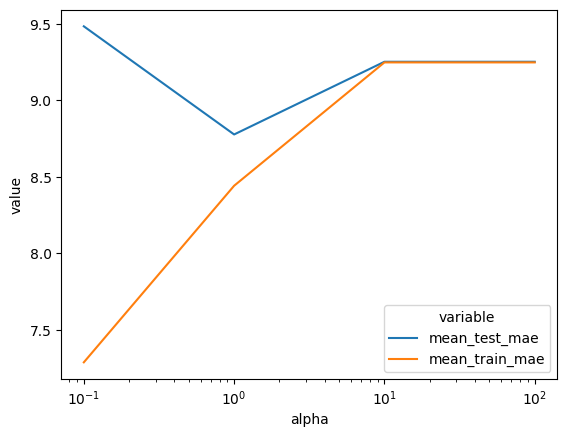

,alpha,mean_test_mae,mean_train_mae
0,0.1,9.482719,7.287089
1,1,8.776057,8.440962
2,10,9.251144,9.246933
3,100,9.251144,9.246933


In [159]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 1, 10, 100],
        # "model__alpha": [0.1],
    }

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning(vit_d, lasso_model, lasso_param_grid)
vit_d_lasso_model_hyperparam_tuning_df

### Ridge

In [160]:
ridge_model = Ridge()

ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000],
    }

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning(vit_d, ridge_model, ridge_param_grid)
vit_d_ridge_model_hyperparam_tuning_df

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-6.677, test=-13.838) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-6.402, test=-12.776) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-6.332, test=-12.562) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-6.576, test=-10.044) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-6.200, test=-12.416) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-6.951, test=-10.655) total time= 1.8min


### DecisionTreeRegressor

In [ ]:
tree_model = DecisionTreeRegressor(random_state=42)

tree_param_grid = {
    "model__max_depth": [5, 20, 50],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning(vit_d, tree_model, tree_param_grid)
vit_d_tree_model_hyperparam_tuning_df

## Best models for Vitamine D

In [153]:
def get_feature_importance_lasso(pipeline: Pipeline, target_attribute, significance_threshold=0.01):
    lasso_coefs = pipeline['model'].coef_
    column_names = pipeline['one_hot_encoder'].get_feature_names_out()

    feature_importnces_lasso = [*zip(column_names, lasso_coefs)]
    feature_importances = pd.DataFrame(feature_importnces_lasso, columns=['feature', 'importance'])
    feature_importances_sorted = feature_importances[feature_importances['importance'].abs() > significance_threshold].sort_values(by='importance', key=abs, ascending=False)

    sns.barplot(feature_importances_sorted, x="importance", y="feature").set(title=target_attribute)
    plt.show()

    return feature_importances_sorted


def show_plots(y_true, y_pred, dataset_label):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0],
        random_state=42,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=42,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle(f"Predictions on a {dataset_label} set")
    plt.tight_layout()
    plt.show()


def train_model(model, target_attribute, feature_importance_method):
    model_scores_df = pd.DataFrame(columns=['model', 'test_set' 'mse', "mae", "rmse", 'r2'])
    # drop rows with missing target_attribute
    cleaned_df = df.dropna(subset=[target_attribute])
    
    X, y = cleaned_df.drop(columns=[target_attribute]), cleaned_df[target_attribute]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    attributes_to_scale = get_continuous_attributes_except(target_attribute)
    scaler = Scaler(PowerTransformer(), attributes_to_scale)
        
    imputer = Imputer(IterativeImputer(max_iter=30, tol=0.01, initial_strategy='median'),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    categorical_attributes)
    
    one_hot_encoder = OneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)
    
    pipeline = Pipeline([('scaler', scaler), ('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)

    train_mse = round(mean_squared_error(y_train, y_pred_train), 3)
    train_mae = round(mean_absolute_error(y_train, y_pred_train), 3)
    train_rmse = round(root_mean_squared_error(y_train, y_pred_train), 3)
    train_r2 = round(r2_score(y_train, y_pred_train), 3)

    val_mse = round(mean_squared_error(y_val, y_pred_val), 3)
    val_mae = round(mean_absolute_error(y_val, y_pred_val), 3)
    val_rmse = round(root_mean_squared_error(y_val, y_pred_val), 3)
    val_r2 = round(r2_score(y_val, y_pred_val), 3)

    show_plots(y_train, y_pred_train, 'training')
    show_plots(y_val, y_pred_val, 'validation')


    model_scores_df.loc[len(model_scores_df)] = [str(model), 'training', train_mse, train_mae, train_rmse,  train_r2]
    model_scores_df.loc[len(model_scores_df)] = [str(model), 'validation', val_mse, val_mae, val_rmse, val_r2]


    feature_importnces = feature_importance_method(pipeline, target_attribute)




    # # TODO: maybe no need to do cross-validation here again?
    
    # # TODO: repeat spowrotem na 3 i 5 splits
    # rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    # all_feature_importances = []

    # for train, test in tqdm(rkf.split(X_train, y_train)):
    #     X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    #     X_test_fold, y_test_fold = X_train.iloc[test], y_train.iloc[test]

    #     pipeline.fit(X_train_fold, y_train_fold)

    #     y_train_fold_pred = pipeline.predict(X_train_fold)

    #     y_test_fold_pred = pipeline.predict(X_test_fold)
        
    #     train_mse = round(mean_squared_error(y_train_fold, y_train_fold_pred), 3)

    #     test_mse = round(mean_squared_error(y_test_fold, y_test_fold_pred), 3)
    #     test_mae = round(mean_absolute_error(y_test_fold, y_test_fold_pred), 3)
    #     test_rmse = round(root_mean_squared_error(y_test_fold, y_test_fold_pred), 3)


    #     show_plots(y_test_fold, y_test_fold_pred)


    #     model_scores_df.loc[len(model_scores_df)] = [str(model), train_mse, test_mse, test_mae, test_rmse]

    #     feature_importnces = feature_importance_method(pipeline, target_attribute)

    #     all_feature_importances.append(list(feature_importnces['feature'].values.tolist()))

    # for feature_importances in all_feature_importances:
    #     print(feature_importances)
    
    return model_scores_df, feature_importnces

0it [00:00, ?it/s]

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


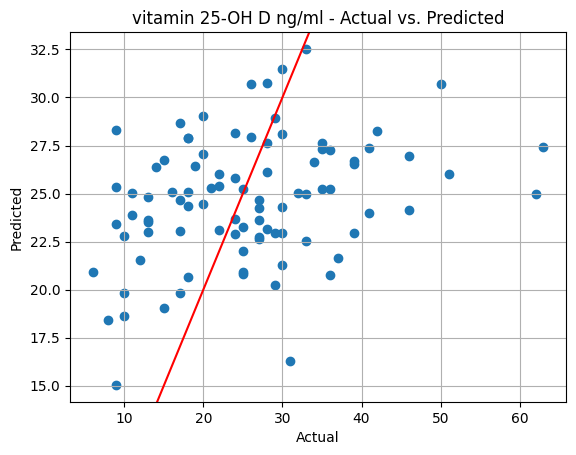

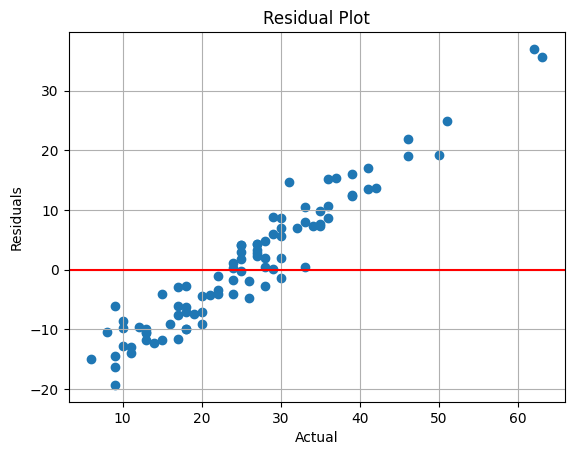

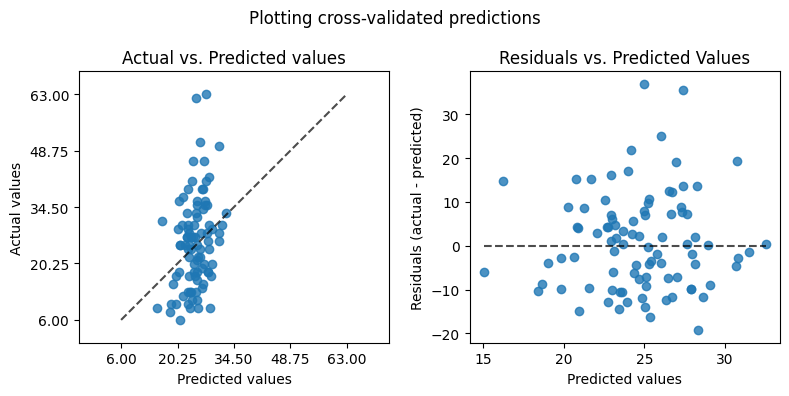

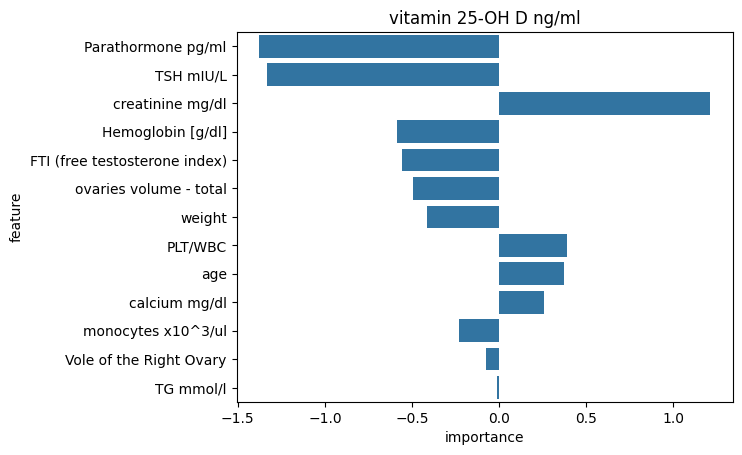

1it [06:50, 410.93s/it]c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


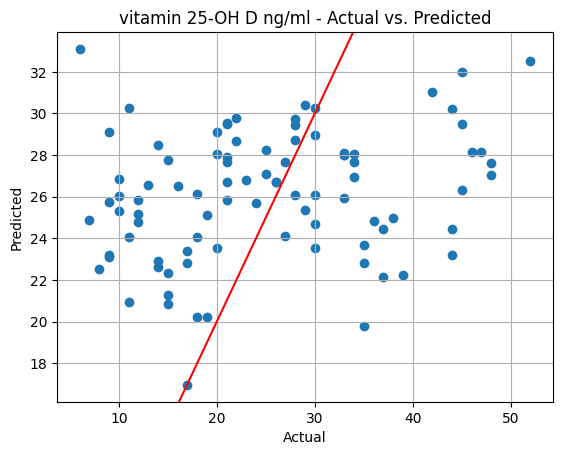

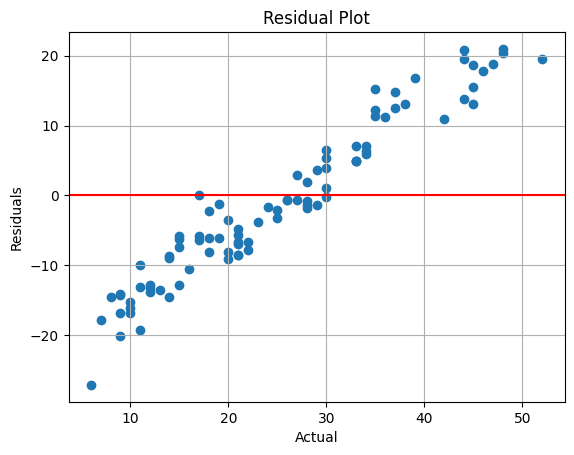

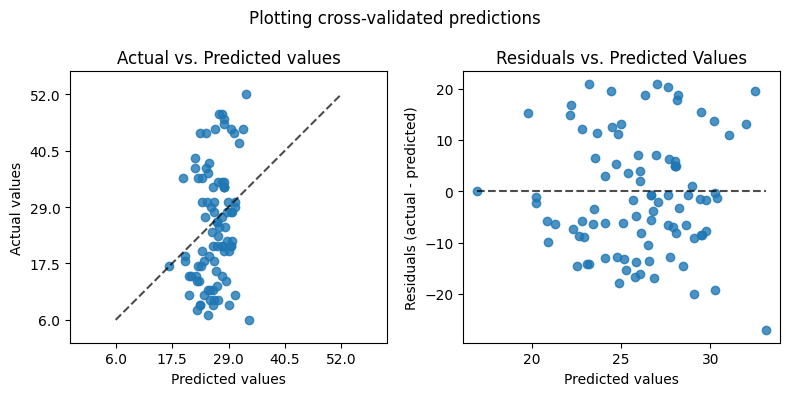

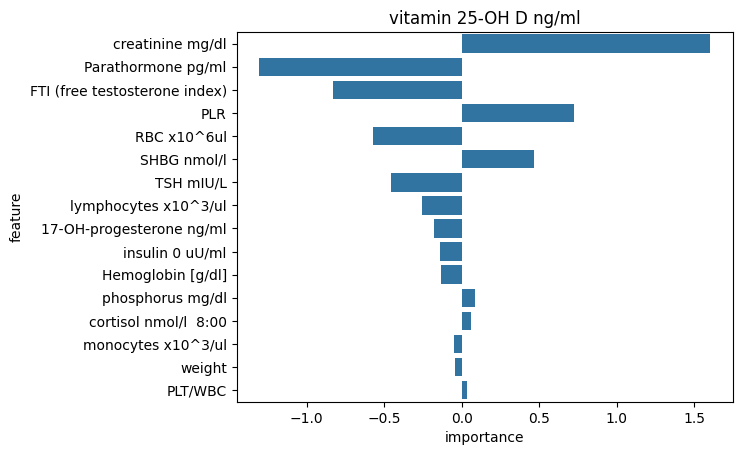

2it [08:59, 244.94s/it]c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


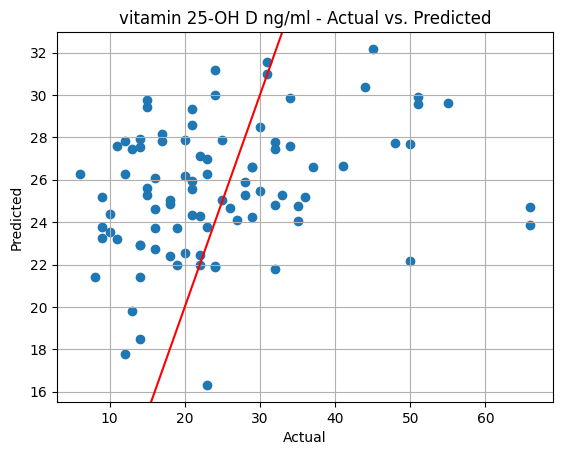

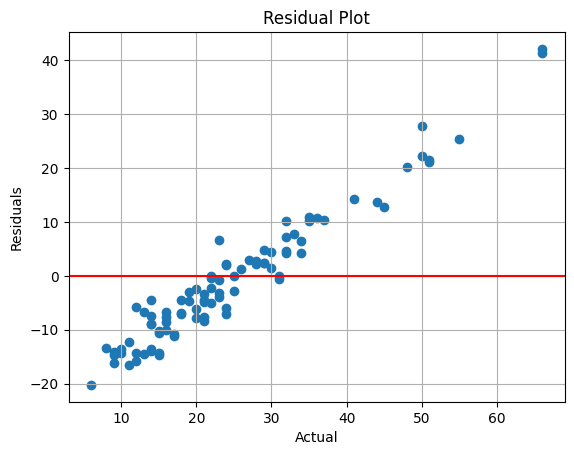

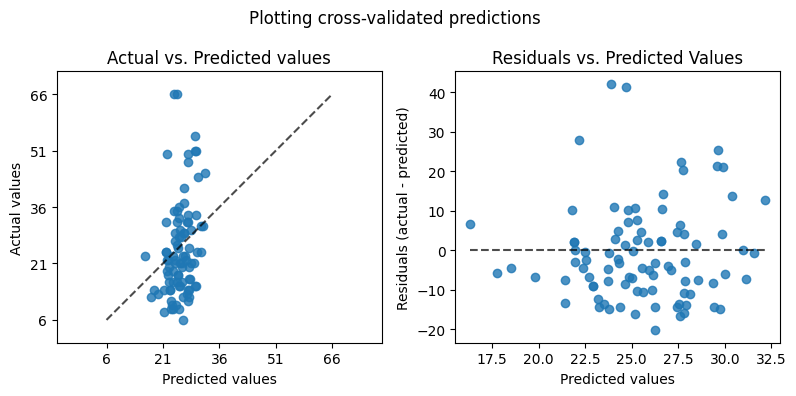

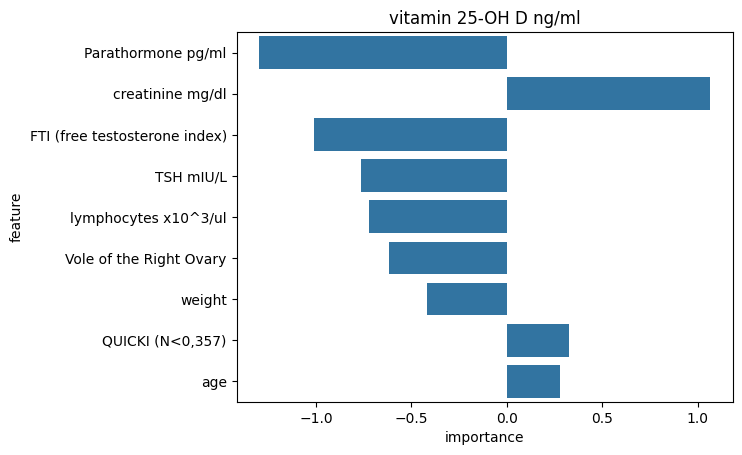

3it [10:59, 187.91s/it]c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


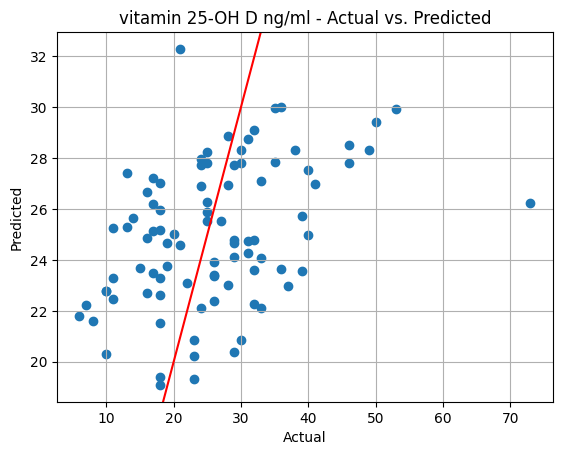

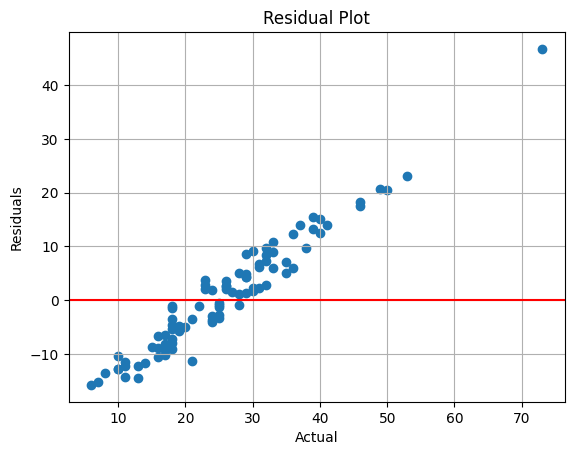

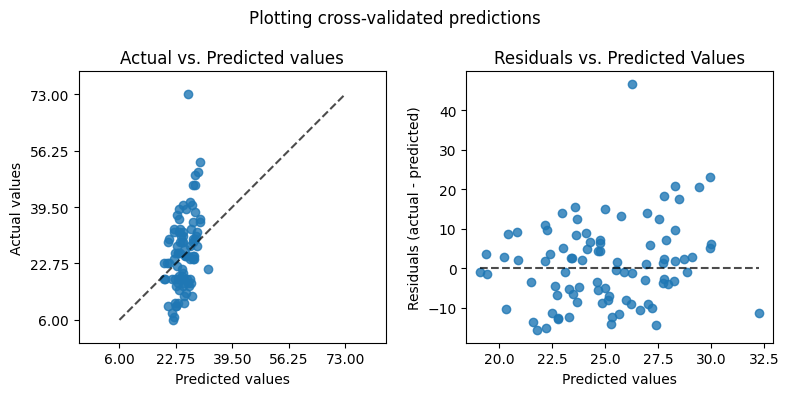

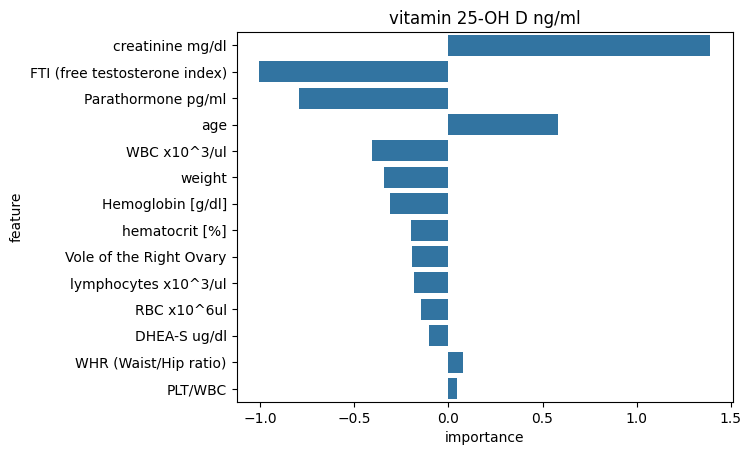

4it [12:58, 160.62s/it]c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


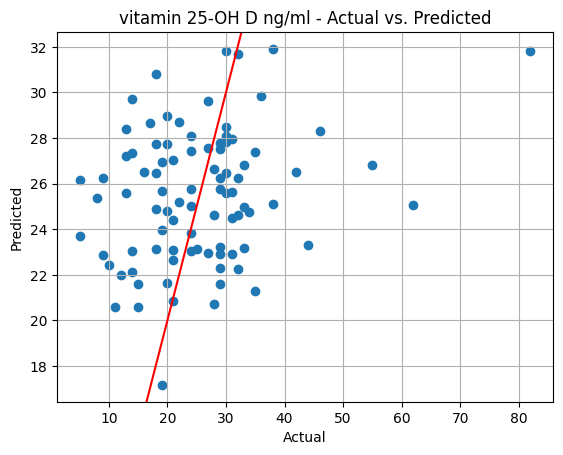

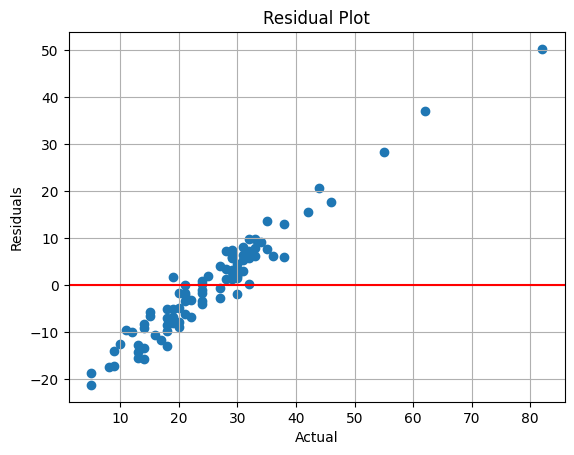

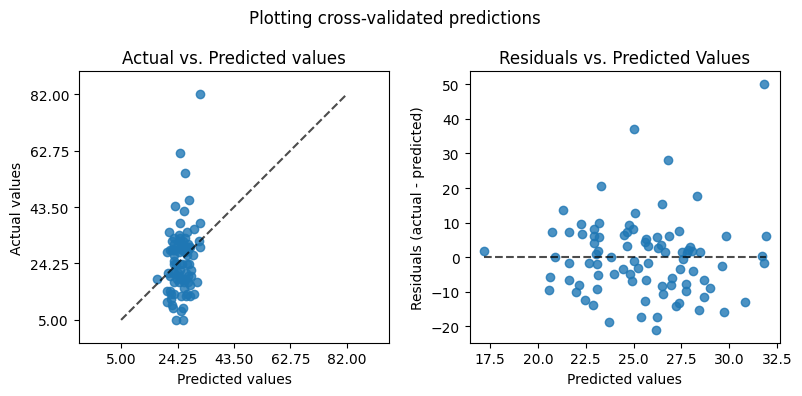

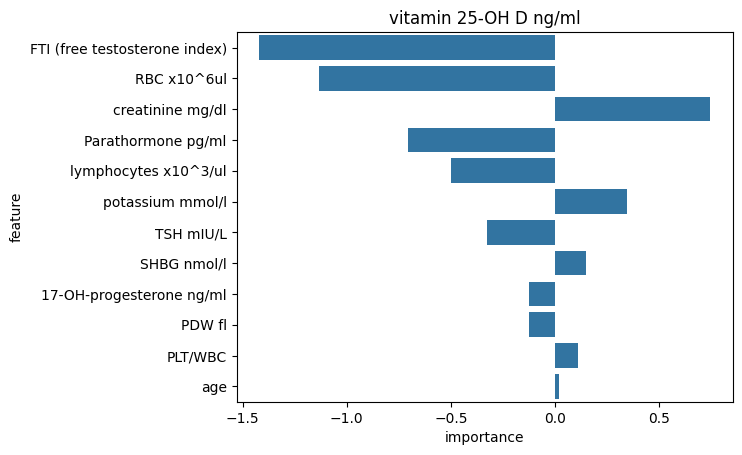

5it [14:57, 179.46s/it]

['Parathormone pg/ml', 'TSH mIU/L', 'creatinine mg/dl', 'Hemoglobin [g/dl]', 'FTI (free testosterone index)', 'ovaries volume - total', 'weight', 'PLT/WBC', 'age', 'calcium mg/dl', 'monocytes x10^3/ul', 'Vole of the Right Ovary', 'TG mmol/l']
['creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)', 'PLR', 'RBC x10^6ul', 'SHBG nmol/l', 'TSH mIU/L', 'lymphocytes x10^3/ul', '17-OH-progesterone ng/ml', 'insulin 0 uU/ml', 'Hemoglobin [g/dl]', 'phosphorus mg/dl', 'cortisol nmol/l  8:00', 'monocytes x10^3/ul', 'weight', 'PLT/WBC']
['Parathormone pg/ml', 'creatinine mg/dl', 'FTI (free testosterone index)', 'TSH mIU/L', 'lymphocytes x10^3/ul', 'Vole of the Right Ovary', 'weight', 'QUICKI (N<0,357)', 'age']
['creatinine mg/dl', 'FTI (free testosterone index)', 'Parathormone pg/ml', 'age', 'WBC x10^3/ul', 'weight', 'Hemoglobin [g/dl]', 'hematocrit [%]', 'Vole of the Right Ovary', 'lymphocytes x10^3/ul', 'RBC x10^6ul', 'DHEA-S ug/dl', 'WHR (Waist/Hip ratio)', 'PLT/WBC']
['FTI (f

,model,train_mse,test_mse,test_mae,test_rmse
0,Lasso(alpha=1),117.259,124.201,8.822,11.145
1,Lasso(alpha=1),116.530,129.803,9.528,11.393
2,Lasso(alpha=1),112.536,148.441,9.376,12.184
3,Lasso(alpha=1),124.204,110.689,8.127,10.521
4,Lasso(alpha=1),120.579,127.776,8.222,11.304


In [154]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, vit_d, get_feature_importance_lasso)
vit_d_model_scores_df
# feature_importnces_lasso


Most important attributes for `witamine D`: 'creatinine mg/dl', 'Parathormone pg/ml', 'FTI (free testosterone index)'

#### Test charts

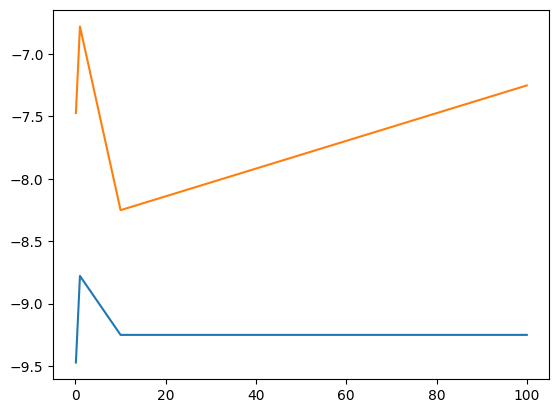

In [30]:
# alphas = grid_search['param_model__alpha']

# mean_test_score = grid_search['mean_test_score']
# mean_train_score = grid_search['mean_train_score']


alphas = [0.1, 1, 10, 100]
mean_test_score = [-9.47238468, -8.77841918, -9.25114413, -9.25114413]
mean_train_score = [-7.47238468, -6.77841918, -8.25114413, -7.25114413]

results_df = pd.DataFrame({'alpha': alphas, 'mean_test_score': mean_test_score, 'mean_train_score': mean_train_score})


plt.plot(alphas, mean_test_score)
plt.plot(alphas, mean_train_score)


<Axes: xlabel='alpha', ylabel='value'>

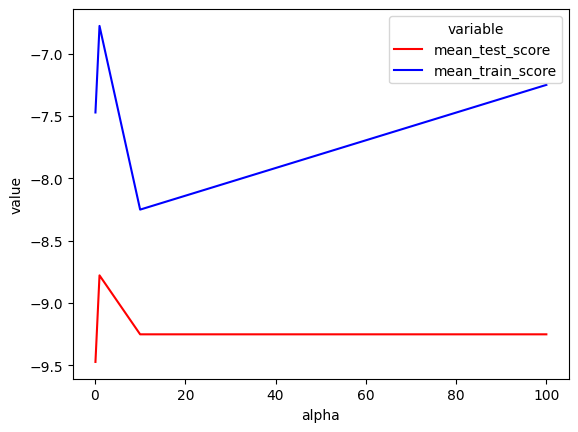

In [33]:
sns.lineplot(x='alpha', y='value', hue='variable', 
             data=pd.melt(results_df, ['alpha']),
             palette=['red', 'blue'])

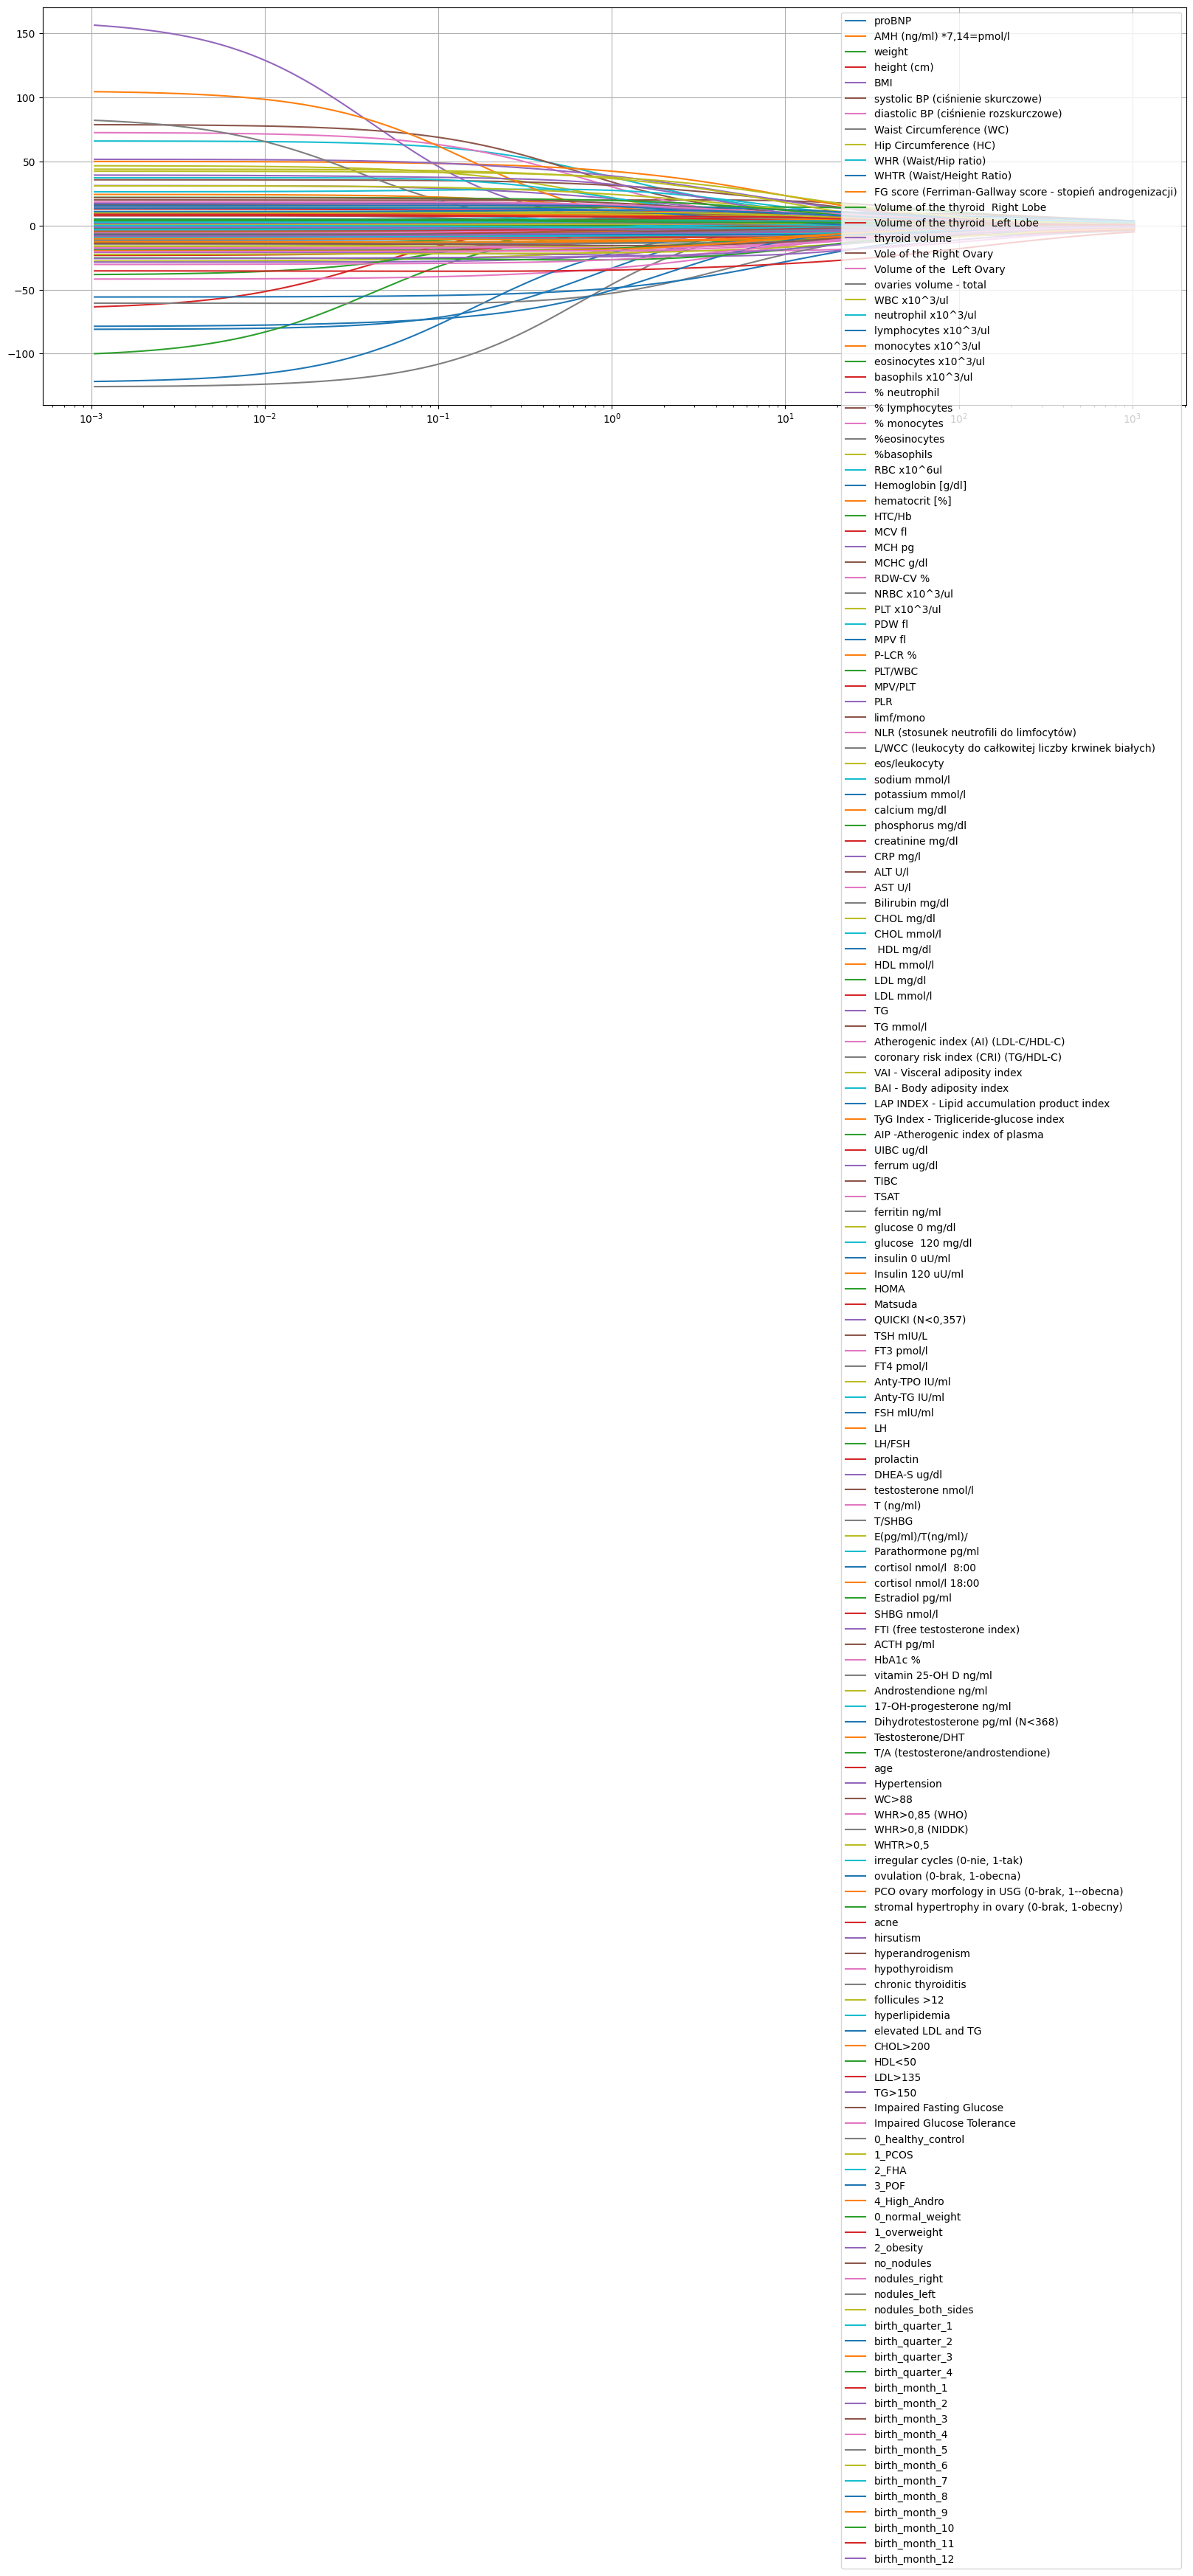

In [38]:
# fajny wykres przedstawiający liczbę zmiennych - może zbyt duży na naszą liczbę zmiennych

coefs=[]
alphas=2**np.arange(10,-10,-.1)
for alpha in alphas:
    ridge= Ridge(alpha=alpha, max_iter=100000).fit(X_train_encoded, y_train)
    coefs.append(ridge.coef_)
coefs=np.array(coefs)

#plot results
N,M=X_train_encoded.shape
plt.figure(figsize=(20,7))
for i in range(M):
    plt.plot(alphas, coefs[:,i], label=f"{list(X_train_encoded.columns)[i]}")
# plt.axvline(x = 10, color = 'b', label = 'best Alpha')
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e+02, tolerance: 3.701e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.732e+02, tolerance: 3.701e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

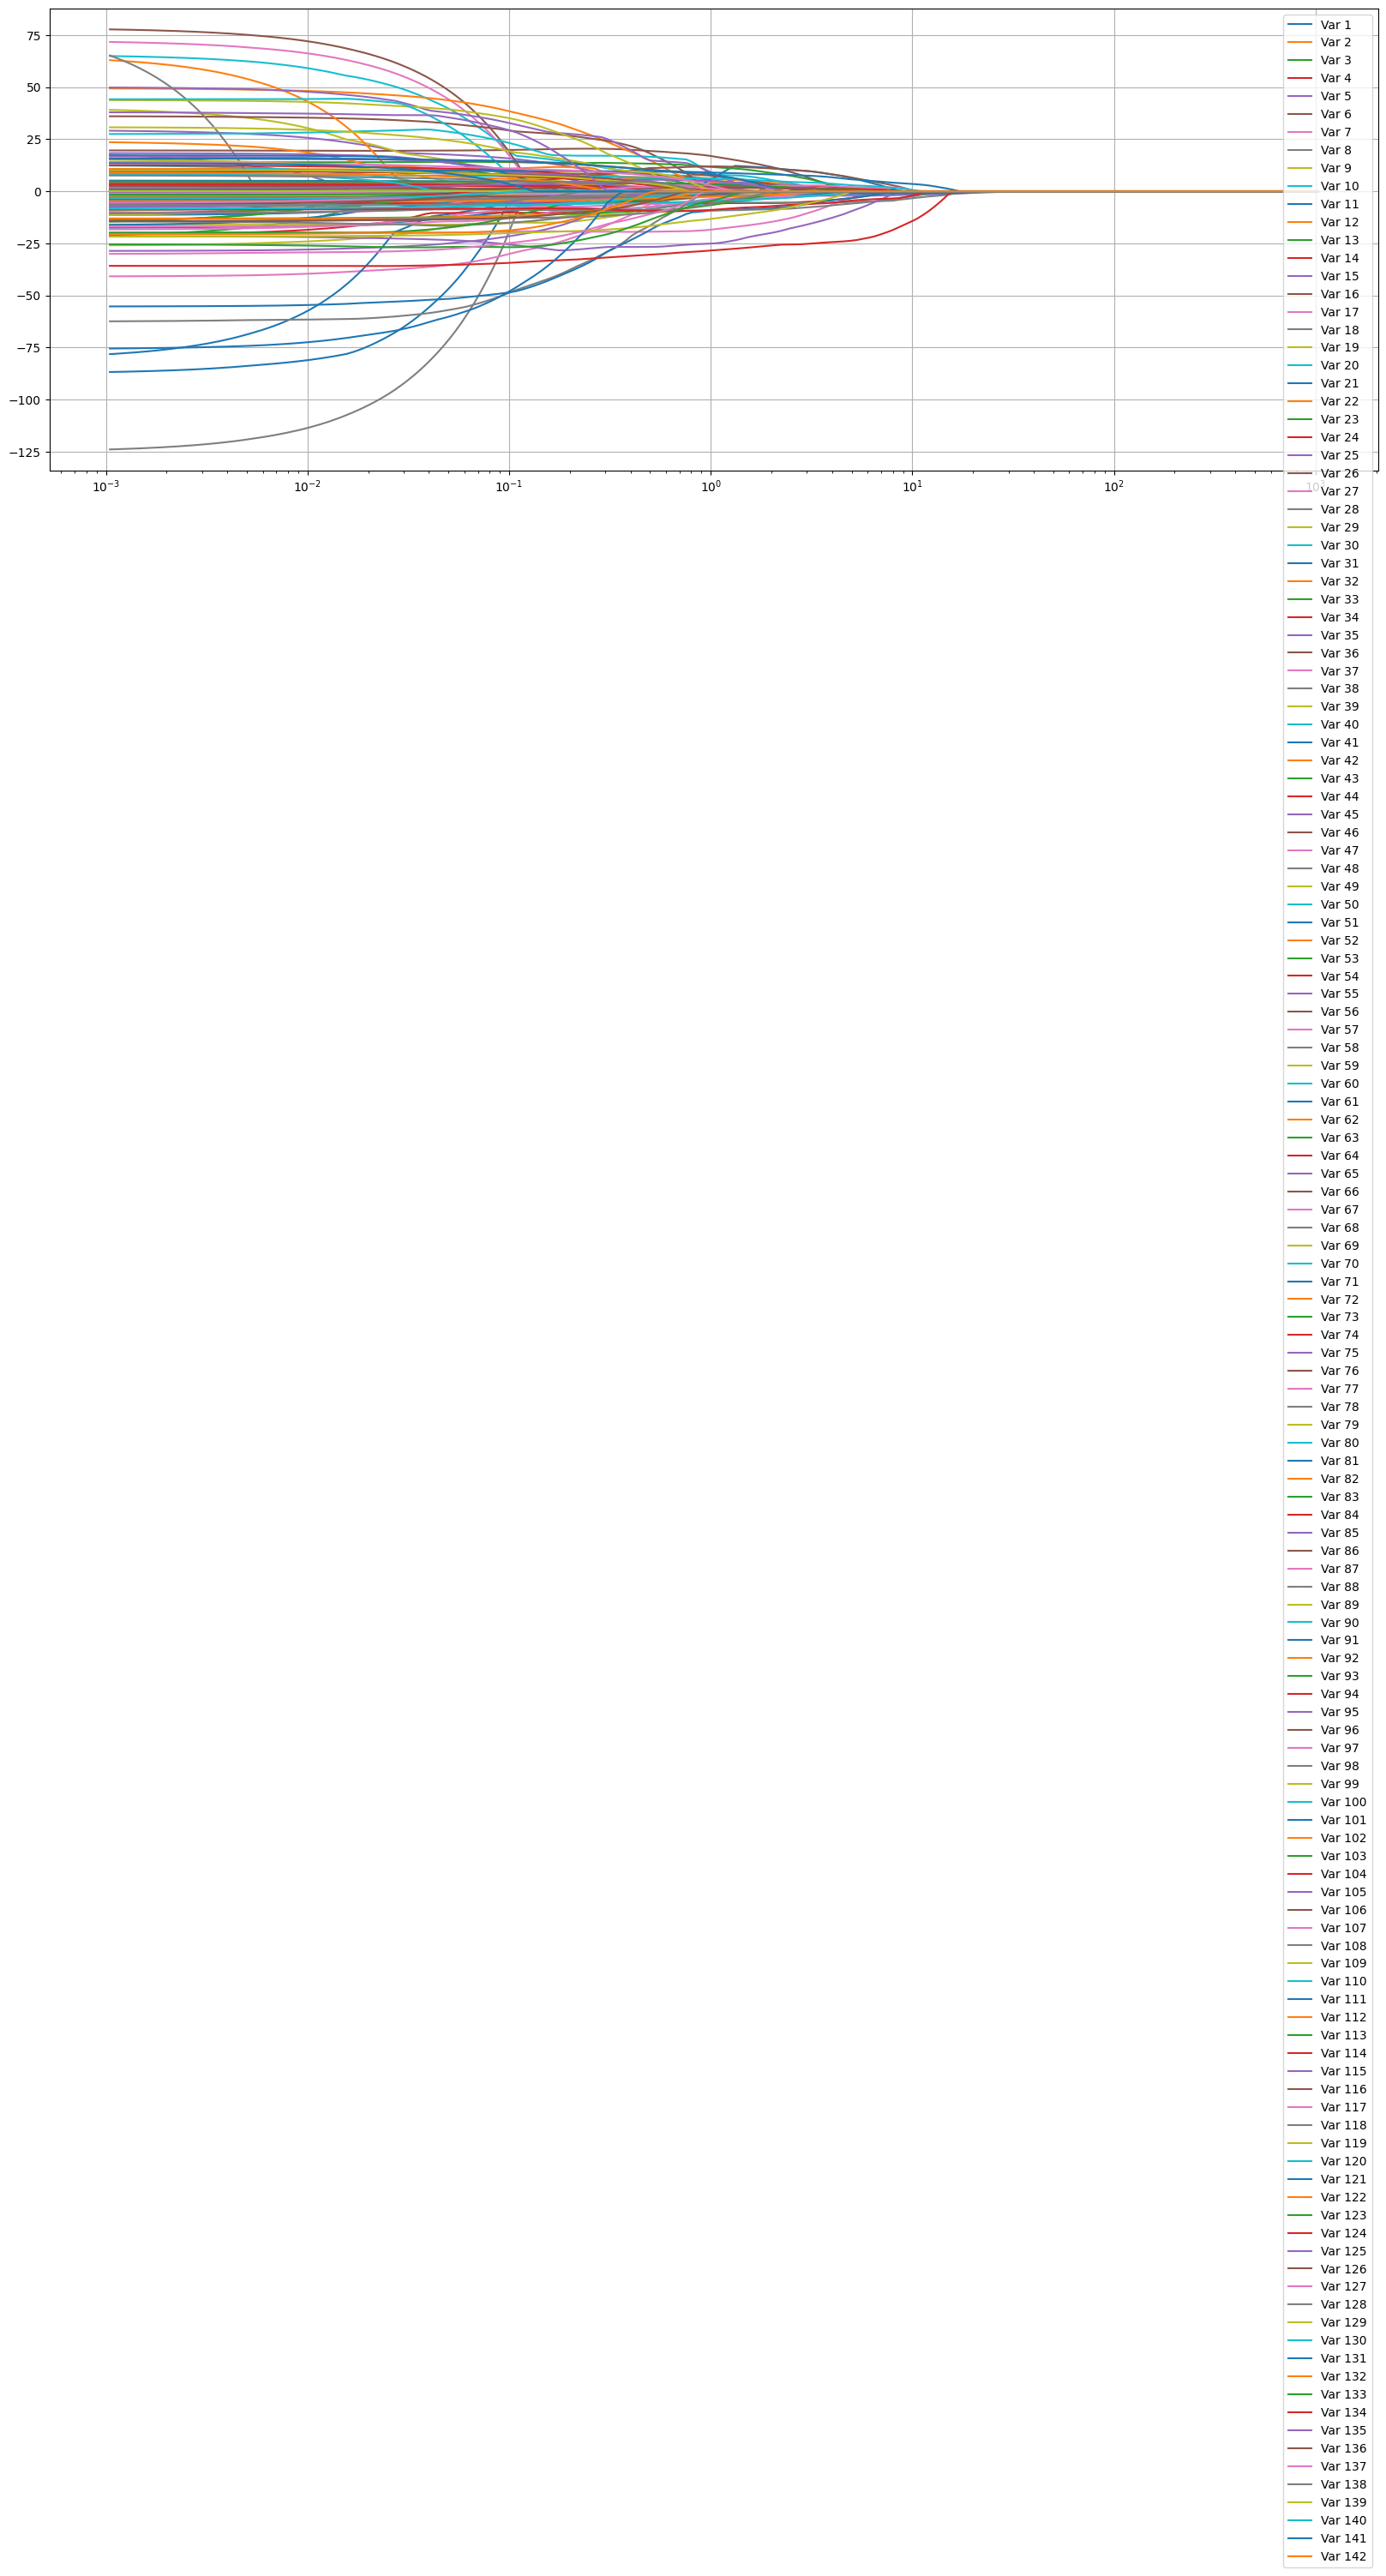

In [37]:
# fajny wykres przedstawiający liczbę zmiennych - może zbyt duży na naszą liczbę zmiennych

coefs=[]
alphas=2**np.arange(10,-10,-.1)
for alpha in alphas:
    ridge= Lasso(alpha=alpha).fit(X_train_encoded, y_train)
    coefs.append(ridge.coef_)
coefs=np.array(coefs)

#plot results
N,M=X_train.shape
plt.figure(figsize=(20,7))
for i in range(M):
    plt.plot(alphas, coefs[:,i], label="Var %d" % (i+1))
# plt.axvline(x = 10, color = 'b', label = 'best Alpha')
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

# Model selection for IGF

# Model selection for prolactin

### Feature selection

In [28]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_preprocessed, y_train)
importances = np.abs(lasso.coef_)

In [29]:

selector = SelectFromModel(model, threshold=0.1)
selector.fit(X_train_preprocessed, y_train)
selected_features = X_train_preprocessed.columns[selector.get_support()]
selected_features

Index(['age'], dtype='object')

In [30]:

result = permutation_importance(model, X_test_preprocessed, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# # Associate each importance value with its corresponding feature name
feature_importances = dict(zip(X_test_preprocessed.columns, importances))

# Print the columns together with their importances
for feature, importance in feature_importances.items():
    if importance != 0:
        print(f"{feature}: {importance}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- birth_month_-0.2
- birth_month_-0.4
- birth_month_-0.6
- birth_month_-0.8
- birth_month_-1.0
- ...
Feature names seen at fit time, yet now missing:
- birth_month_-0.16666666666666666
- birth_month_-0.3333333333333333
- birth_month_-0.5
- birth_month_-0.6666666666666666
- birth_month_-0.8333333333333334
- ...


In [31]:
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train_preprocessed, y_train)
importances = rfe.ranking_

feature_importances = dict(zip(X_test_preprocessed.columns, importances))

sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1])

# Print the columns together with their importances
for feature, importance in sorted_feature_importances:
    if importance != 0:
        print(f"{feature}: {importance}")

WHR (Waist/Hip ratio): 1
% lymphocytes : 1
P-LCR %: 1
HOMA: 1
age: 1
ALT U/l: 2
hematocrit [%]: 3
PLT x10^3/ul: 4
Estradiol pg/ml: 5
LDL mmol/l: 6
MCH pg: 7
glucose  120 mg/dl: 8
Dihydrotestosterone pg/ml (N<368): 9
MPV fl: 10
CRP mg/l: 11
LH/FSH: 12
FT4 pmol/l: 13
FT3 pmol/l: 14
VAI - Visceral adiposity index: 15
ovaries volume - total: 16
neutrophil x10^3/ul: 17
RDW-CV %: 18
Matsuda: 19
TIBC: 20
Anty-TG IU/ml: 21
cortisol nmol/l  8:00: 22
TSH mIU/L: 23
T/SHBG: 24
thyroid volume: 25
CHOL mg/dl : 26
overweight_1.0: 27
FG score (Ferriman-Gallway score - stopień androgenizacji): 28
Hemoglobin [g/dl]: 29
lymphocytes x10^3/ul: 30
Anty-TPO IU/ml: 31
AST U/l: 32
Vole of the Right Ovary: 33
DHEA-S ug/dl: 34
nodules_0.0: 35
T (ng/ml): 36
potassium mmol/l: 37
SHBG nmol/l: 38
Atherogenic index (AI) (LDL-C/HDL-C) : 39
Volume of the thyroid  Left Lobe: 40
Parathormone pg/ml: 41
BAI - Body adiposity index: 42
% neutrophil : 43
QUICKI (N<0,357): 44
glucose 0 mg/dl: 45
birth_month_0.6: 46
Testosteron

In [32]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_preprocessed.shape[1]):

    print(f"{f + 1}. Feature '{X_train_preprocessed.columns[indices[f]]}' ({importances[indices[f]]})")

Feature ranking:
1. Feature 'age' (0.11558109256072505)
2. Feature '% lymphocytes ' (0.037067424059781806)
3. Feature '17-OH-progesterone ng/ml' (0.02265471763561137)
4. Feature 'insulin 0 uU/ml' (0.02005921061817757)
5. Feature 'ALT U/l' (0.020031333707779757)
6. Feature 'TIBC' (0.018341271049474084)
7. Feature 'P-LCR %' (0.0180263764801652)
8. Feature 'DHEA-S ug/dl' (0.017381523781329275)
9. Feature 'E(pg/ml)/T(ng/ml)/' (0.013925019525298177)
10. Feature 'Dihydrotestosterone pg/ml (N<368)' (0.01381382592287395)
11. Feature 'FT3 pmol/l' (0.013211499351731826)
12. Feature 'MPV fl' (0.013196172022832464)
13. Feature 'QUICKI (N<0,357)' (0.012496564375672798)
14. Feature 'ferritin ng/ml' (0.011887067391901414)
15. Feature 'Hemoglobin [g/dl]' (0.011773180214576847)
16. Feature 'WHTR (Waist/Height Ratio)' (0.010941850797454569)
17. Feature 'neutrophil x10^3/ul' (0.01090754824336664)
18. Feature 'phosphorus mg/dl' (0.010880616821887323)
19. Feature 'SHBG nmol/l' (0.010875881110953065)
20. Fe